# ResStock Matching

The purpose of this notebook is to load ResStock and then match TCAD entries to Resstock

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from pathlib import Path
import pandas as pd

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',10)

RESSTOCK_RAW = 'data/raw/resstock_tx_baseline_metadata_and_annual_results.parquet'

def load_resstock(*,state='TX'):
    metadata_url = f"https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state={state}/parquet/{state}_baseline_metadata_and_annual_results.parquet"
    # metadata_url = f"https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/resstock_dataset_2024.1/resstock_tmy3/metadata_and_annual_results/by_state/state=TX/parquet/Baseline/TX_baseline_metadata_and_annual_results.parquet"
    return pd.read_parquet(metadata_url)

if not Path(RESSTOCK_RAW).exists():
    resstock_df_raw = load_resstock()
    resstock_df_raw.to_parquet(RESSTOCK_RAW)
else:
    resstock_df_raw = pd.read_parquet(RESSTOCK_RAW)


## Preview ResStock Data

This section is just to see what kind of data ResStock has and can be safely skipped.

Potentially matchable columns include:
- Floor area (in.sqft)
- input city (in.city)
- Building type (in.geometry_building_type_acs,in.geometry_building_type_height,in.geometry_building_type_recs)
- Federal poverty level (in.federal_poverty_level)
- Foundation type (in.geometry_foundation_type)
- Floors (in.geometry_stories)
- Income ()
- Orientation 
- Year built: in.vintage,in.vintage_acs

Other stuff: solar, roof material

In [55]:
resstock_df_raw[resstock_df_raw['in.city']=='TX, Austin']

,upgrade,weight,applicability,in.sqft,in.ahs_region,in.ashrae_iecc_climate_zone_2004,in.ashrae_iecc_climate_zone_2004_2_a_split,in.bathroom_spot_vent_hour,in.bedrooms,in.building_america_climate_zone,in.cec_climate_zone,in.ceiling_fan,in.census_division,in.census_division_recs,in.census_region,in.city,in.clothes_dryer,in.clothes_washer,in.clothes_washer_presence,in.cooking_range,in.cooling_setpoint,in.cooling_setpoint_has_offset,in.cooling_setpoint_offset_magnitude,in.cooling_setpoint_offset_period,in.corridor,in.county,in.county_and_puma,in.dehumidifier,in.dishwasher,in.door_area,in.doors,in.ducts,in.eaves,in.electric_vehicle,in.emissions_electricity_folders,in.emissions_electricity_units,in.emissions_electricity_values_or_filepaths,in.emissions_fossil_fuel_units,in.emissions_fuel_oil_values,in.emissions_natural_gas_values,in.emissions_propane_values,in.emissions_scenario_names,in.emissions_types,in.emissions_wood_values,in.federal_poverty_level,in.generation_and_emissions_assessment_region,in.geometry_attic_type,in.geometry_building_horizontal_location_mf,in.geometry_building_horizontal_location_sfa,in.geometry_building_level_mf,in.geometry_building_number_units_mf,in.geometry_building_number_units_sfa,in.geometry_building_type_acs,in.geometry_building_type_height,in.geometry_building_type_recs,in.geometry_floor_area,in.geometry_floor_area_bin,in.geometry_foundation_type,in.geometry_garage,in.geometry_stories,in.geometry_stories_low_rise,in.geometry_story_bin,in.geometry_wall_exterior_finish,in.geometry_wall_type,in.has_pv,in.heating_fuel,in.heating_setpoint,in.heating_setpoint_has_offset,in.heating_setpoint_offset_magnitude,in.heating_setpoint_offset_period,in.holiday_lighting,in.hot_water_distribution,in.hot_water_fixtures,in.hvac_cooling_efficiency,in.hvac_cooling_partial_space_conditioning,in.hvac_cooling_type,in.hvac_has_ducts,in.hvac_has_shared_system,in.hvac_has_zonal_electric_heating,in.hvac_heating_efficiency,in.hvac_heating_type,in.hvac_heating_type_and_fuel,in.hvac_secondary_heating_efficiency,in.hvac_secondary_heating_type_and_fuel,in.hvac_shared_efficiencies,in.hvac_system_is_faulted,in.hvac_system_single_speed_ac_airflow,in.hvac_system_single_speed_ac_charge,in.hvac_system_single_speed_ashp_airflow,in.hvac_system_single_speed_ashp_charge,in.income,in.income_recs_2015,in.income_recs_2020,in.infiltration,in.insulation_ceiling,in.insulation_floor,in.insulation_foundation_wall,in.insulation_rim_joist,in.insulation_roof,in.insulation_slab,in.insulation_wall,in.interior_shading,in.iso_rto_region,in.lighting,in.lighting_interior_use,in.lighting_other_use,in.location_region,in.mechanical_ventilation,in.misc_extra_refrigerator,in.misc_freezer,in.misc_gas_fireplace,in.misc_gas_grill,in.misc_gas_lighting,in.misc_hot_tub_spa,in.misc_pool,in.misc_pool_heater,in.misc_pool_pump,in.misc_well_pump,in.natural_ventilation,in.neighbors,in.occupants,in.orientation,in.overhangs,in.plug_load_diversity,in.plug_loads,in.puma,in.puma_metro_status,in.pv_orientation,in.pv_system_size,in.radiant_barrier,in.range_spot_vent_hour,in.reeds_balancing_area,in.refrigerator,in.roof_material,in.schedules,in.simulation_control_run_period_begin_day_of_month,in.simulation_control_run_period_begin_month,in.simulation_control_run_period_calendar_year,in.simulation_control_run_period_end_day_of_month,in.simulation_control_run_period_end_month,in.simulation_control_timestep,in.solar_hot_water,in.state,in.tenure,in.units_represented,in.usage_level,in.vacancy_status,in.vintage,in.vintage_acs,in.water_heater_efficiency,in.water_heater_fuel,in.water_heater_in_unit,in.weather_file_city,in.weather_file_latitude,in.weather_file_longitude,in.window_areas,in.windows,out.params.door_area_ft_2,out.params.duct_unconditioned_surface_area_ft_2,out.params.floor_area_attic_ft_2,out.params.floor_area_attic_insulation_increase_ft_2_delta_r_value,out.params.floor_area_conditioned_infiltration_reduction_ft_2_delta_ach_50,out.params.floor_area_foundation_ft_2,out.params.floor

ResStock has three columns that describes the building type. Here we will take a look
at if there are any differences.

In [56]:
resstock_df_raw['in.geometry_building_type_recs'].unique()

array(['Single-Family Detached', 'Multi-Family with 5+ Units',
       'Multi-Family with 2 - 4 Units', 'Single-Family Attached',
       'Mobile Home'], dtype=object)

In [57]:
resstock_df_raw['in.geometry_building_type_acs'].unique()

array(['Single-Family Detached', '10 to 19 Unit', '3 or 4 Unit',
       'Single-Family Attached', 'Mobile Home', '20 to 49 Unit', '2 Unit',
       '50 or more Unit', '5 to 9 Unit'], dtype=object)

In [58]:
resstock_df_raw['in.geometry_building_type_height'].unique()

array(['Single-Family Detached', 'Multifamily with 5+ units, 1-3 stories',
       'Multifamily with 2-4 Units', 'Single-Family Attached',
       'Mobile Home', 'Multifamily with 5+ units, 8+ stories',
       'Multifamily with 5+ units, 4-7 stories'], dtype=object)

Number of single family detached for Austin in the ResStock database.

In [59]:
len(resstock_df_raw[(resstock_df_raw['in.city']=='TX, Austin')&(resstock_df_raw['in.geometry_building_type_height']=='Single-Family Detached')])

734

Number of single family attached for Austin in the ResStock database.

In [60]:
len(resstock_df_raw[(resstock_df_raw['in.city']=='TX, Austin')&(resstock_df_raw['in.geometry_building_type_height']=='Single-Family Attached')])

75

In [61]:
resstock_df_raw['in.geometry_foundation_type'].unique()

array(['Slab', 'Vented Crawlspace', 'Ambient', 'Unheated Basement',
       'Unvented Crawlspace', 'Heated Basement'], dtype=object)

In [62]:
resstock_df_raw['in.roof_material'].unique()

array(['Composition Shingles', 'Asphalt Shingles, Medium', 'Metal, Dark',
       'Slate', 'Wood Shingles', 'Tile, Clay or Ceramic',
       'Tile, Concrete'], dtype=object)

In [63]:
resstock_df_raw['in.vintage'].unique()

array(['1970s', '2000s', '1950s', '1980s', '2010s', '1960s', '1940s',
       '1990s', '<1940'], dtype=object)

## Select Austin Single Family Detached

In [64]:
atx_single_family_detached = resstock_df_raw[(resstock_df_raw['in.city']=='TX, Austin')
                                             &(resstock_df_raw['in.geometry_building_type_height']
                                               =='Single-Family Detached')].copy()#.reset_index()

usecols = ['in.sqft','in.vintage','in.geometry_stories','in.geometry_floor_area',
           'in.geometry_foundation_type','in.geometry_building_type_height','in.city',
           'in.has_pv','in.cooling_setpoint','in.federal_poverty_level','in.income','in.roof_material']

resstock = atx_single_family_detached[usecols].copy()
resstock

,in.sqft,in.vintage,in.geometry_stories,in.geometry_floor_area,in.geometry_foundation_type,in.geometry_building_type_height,in.city,in.has_pv,in.cooling_setpoint,in.federal_poverty_level,in.income,in.roof_material
bldg_id,,,,,,,,,,,,
209,2663.0,2000s,2,2500-2999,Slab,Single-Family Detached,"TX, Austin",No,78F,400%+,180000-199999,"Asphalt Shingles, Medium"
384,1690.0,1980s,2,1500-1999,Slab,Single-Family Detached,"TX, Austin",No,75F,200-300%,25000-29999,Composition Shingles
637,1220.0,1990s,1,1000-1499,Slab,Single-Family Detached,"TX, Austin",No,70F,150-200%,25000-29999,"Asphalt Shingles, Medium"
2001,1220.0,1970s,1,1000-1499,Slab,Single-Family Detached,"TX, Austin",No,75F,300-400%,80000-99999,Composition Shingles
3919,8194.0,2000s,2,4000+,Slab,Single-Family Detached,"TX, Austin",No,78F,400%+,200000+,Composition Shingles
...,...,...,...,...,...,...,...,...,...,...,...,...
547367,1690.0,1940s,1,1500-1999,Slab,Single-Family Detached,"TX, Austin",No,75F,400%+,200000+,Composition Shingles
548201,2663.0,1990s,2,2500-2999,Slab,Single-Family Detached,"TX, Austin",No,80F,200-300%,60000-69999,Composition Shingles
548503,1690.0,2000s,1,1500-1999,Slab,Single-Family Detached,"TX, Austin",Yes,76F,400%+,80000-99999,"Asphalt Shingles, Medium"


## Analysis of ATX ResStock

In [65]:
resstock['in.geometry_floor_area'].unique()

array(['2500-2999', '1500-1999', '1000-1499', '4000+', '3000-3999',
       '2000-2499', '750-999', '500-749', '0-499'], dtype=object)

In [66]:
tcad = pd.read_parquet('data/processed/TCAD_78733_78741_merged_tables.parquet')

# There are 10 bad results, remove them
tcad = tcad[tcad['yr_built']!=0]

Text(0.5, 1.0, '78733 and 78741 Combined')

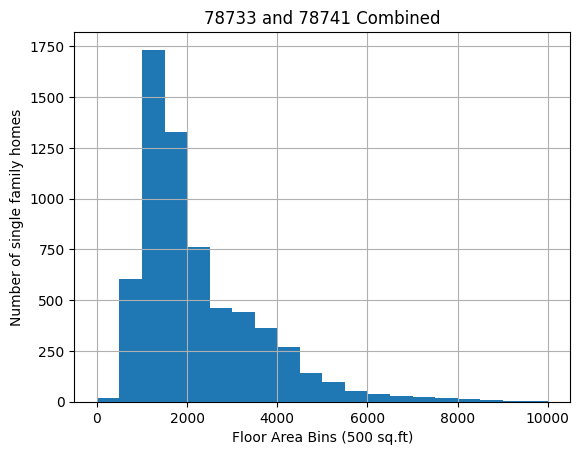

In [69]:
tcad['main_area'].hist(bins=list(range(0,10500,500)))
plt.xlabel('Floor Area Bins (500 sq.ft)')
plt.ylabel('Number of single family homes')
plt.title('78733 and 78741 Combined')

Text(0.5, 1.0, 'Low Income Zip Code (78741)')

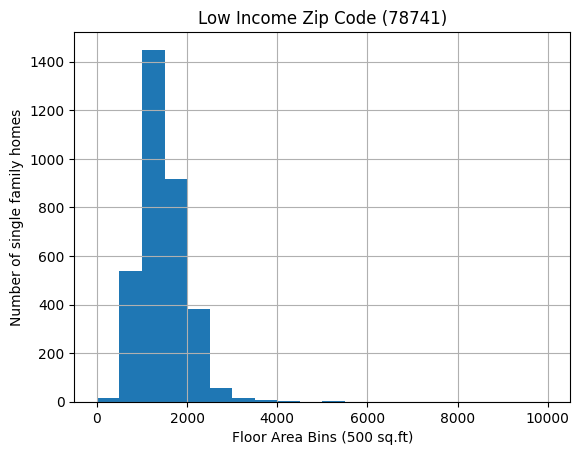

In [67]:
import matplotlib.pyplot as plt
tcad.loc[tcad['situs_zip']=='78741','main_area'].hist(bins=list(range(0,10500,500)))
plt.xlabel('Floor Area Bins (500 sq.ft)')
plt.ylabel('Number of single family homes')
plt.title('Low Income Zip Code (78741)')


Text(0.5, 1.0, 'High Income Zip Code (78733)')

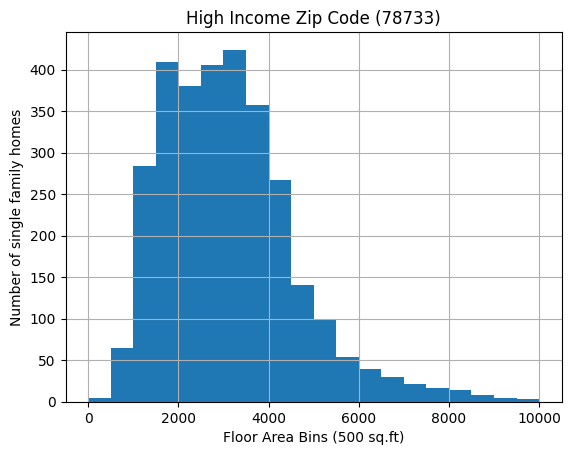

In [68]:
tcad.loc[tcad['situs_zip']=='78733','main_area'].hist(bins=list(range(0,10500,500)))
plt.xlabel('Floor Area Bins (500 sq.ft)')
plt.ylabel('Number of single family homes')
plt.title('High Income Zip Code (78733)')

Text(0.5, 1.0, 'ResStock (Austin)')

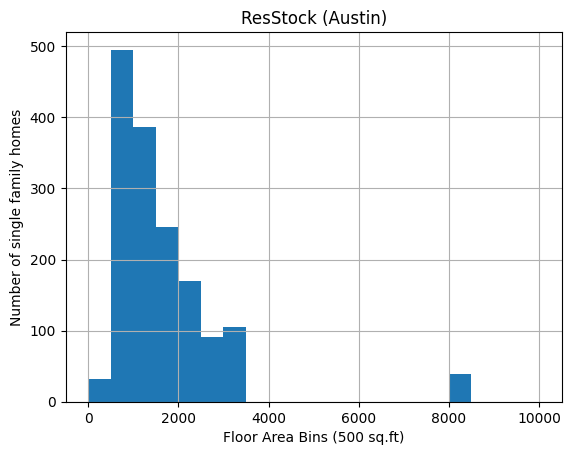

In [101]:
resstock_df_raw.loc[resstock_df_raw['in.city']=='TX, Austin','in.sqft'].hist(bins=list(range(0,10500,500)))
plt.xlabel('Floor Area Bins (500 sq.ft)')
plt.ylabel('Number of single family homes')
plt.title('ResStock (Austin)')

Text(0.5, 1.0, 'ResStock (Texas)')

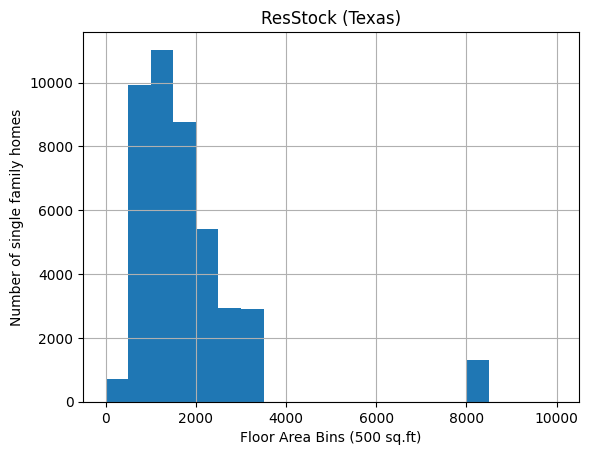

In [70]:
resstock_df_raw['in.sqft'].hist(bins=list(range(0,10500,500)))
plt.xlabel('Floor Area Bins (500 sq.ft)')
plt.ylabel('Number of single family homes')
plt.title('ResStock (Texas)')

In [71]:
resstock[(resstock['in.vintage']=='1990s') & (resstock['in.geometry_stories']=='1') & (resstock['in.geometry_floor_area']=='1500-1999')]

,in.sqft,in.vintage,in.geometry_stories,in.geometry_floor_area,in.geometry_foundation_type,in.geometry_building_type_height,in.city,in.has_pv,in.cooling_setpoint,in.federal_poverty_level,in.income,in.roof_material
bldg_id,,,,,,,,,,,,
5240,1690.0,1990s,1,1500-1999,Slab,Single-Family Detached,"TX, Austin",No,76F,400%+,120000-139999,"Asphalt Shingles, Medium"
103407,1690.0,1990s,1,1500-1999,Ambient,Single-Family Detached,"TX, Austin",No,80F,400%+,70000-79999,Wood Shingles
141766,1690.0,1990s,1,1500-1999,Slab,Single-Family Detached,"TX, Austin",No,75F,400%+,180000-199999,Composition Shingles
159446,1690.0,1990s,1,1500-1999,Vented Crawlspace,Single-Family Detached,"TX, Austin",No,80F,400%+,100000-119999,"Asphalt Shingles, Medium"
174254,1690.0,1990s,1,1500-1999,Slab,Single-Family Detached,"TX, Austin",No,72F,400%+,80000-99999,Composition Shingles
...,...,...,...,...,...,...,...,...,...,...,...,...
293505,1690.0,1990s,1,1500-1999,Slab,Single-Family Detached,"TX, Austin",No,78F,200-300%,30000-34999,Wood Shingles
338391,1690.0,1990s,1,1500-1999,Ambient,Single-Family Detached,"TX, Austin",No,70F,400%+,140000-159999,"Asphalt Shingles, Medium"
340680,1690.0,1990s,1,1500-1999,Ambient,Single-Family Detached,"TX, Austin",No,70F,400%+,200000+,Composition Shingles


## Start matching results

Check to see what roofing types ResStock has.

In [72]:
tcad['Roof Covering'].unique()

['COMPOSITIO', 'TILE', 'METAL', 'WOOD SHING', NaN, 'OTHER', 'BUILT-UP']
Categories (170, object): ['07', '08', '09', '1', ..., 'UQ', 'W', 'WOOD POST', 'WOOD SHING']

Resstock does not have 2020s vintage.

In [73]:
resstock['in.vintage'].unique()

array(['2000s', '1980s', '1990s', '1970s', '1960s', '2010s', '1950s',
       '<1940', '1940s'], dtype=object)

In [74]:
resstock['in.roof_material'].unique()

array(['Asphalt Shingles, Medium', 'Composition Shingles',
       'Wood Shingles', 'Metal, Dark', 'Tile, Clay or Ceramic',
       'Tile, Concrete', 'Slate'], dtype=object)

In [75]:
tcad['Foundation'].unique()

['SLAB', NaN, 'PIER AND B', 'BLOCKS', 'WOOD POST', 'OTHER']
Categories (170, object): ['07', '08', '09', '1', ..., 'UQ', 'W', 'WOOD POST', 'WOOD SHING']

In [76]:
resstock['in.geometry_foundation_type'].unique()

array(['Slab', 'Vented Crawlspace', 'Ambient', 'Unvented Crawlspace'],
      dtype=object)

We combine the 'Tile, clay or ceramic' and the 'Tile, concrete' labels from ResStock into  'Tile, all' to make matching easier.

In [77]:
def find_vintage(yr):
    if yr < 1940:
        return '<1940'
    elif yr > 2010:
        return '2010s'
    else:
        return f'{int(yr/10)}0s'  # Buildings in 2020s get mapped to 2010s
    
def find_area_bin(tcad_area):
    # RESTOCK has no buildings from 3500-8000
    if tcad_area>=6000:
        return '4000+'
    elif tcad_area>=3000:
        return '3000-3999'
    elif tcad_area >=1000:
        n=int((tcad_area-1000)/500)*500+1000
        return f'{n}-{n+499}'
    elif tcad_area >=500:
        n=int((tcad_area-500)/250)*250+500
        return f'{n}-{n+249}'
    else:
        return '0-499'

def find_foundation(tcad_foundation):
    foundation_map = {
        'SLAB':'Slab',
        'PIER AND B':'Ambient',
        'WOOD POST':'Ambient'
    }
    return foundation_map.get(tcad_foundation,None)

# On the restock dataframe, combine the two types of tiles into one category
resstock['in.roof_material'] = resstock['in.roof_material'].replace('Tile, Clay or Ceramic','Tile, all').replace('Tile, Concrete','Tile, all')

def find_roof_material(tcad_material):
    tcad_resstock_roof = {
        'COMPOSITIO':'Composition Shingles',
        'WOOD SHING':'Wood Shingles',
        'METAL':'Metal, Dark',
        'TILE':'Tile, all'
    }
    return tcad_resstock_roof.get(tcad_material,None)

tcad['vintage']=tcad['yr_built'].apply(find_vintage)
tcad['geometry_floor_area']=tcad['main_area'].apply(find_area_bin)
tcad['geometry_foundation_type']=tcad['Foundation'].apply(find_foundation)
tcad['roof_material']=tcad['Roof Covering'].apply(find_roof_material)

Matching order (if dataframe empty, fallback to next step)
1. Year & Num Floors & Area & Foundation & Roof
2. Year & Num Floors & Area & Roof
3. Year & Num Floors & Area & Foundation
4. Year & Area 
5. Year

In [78]:
def search(tcad):
    mask1 = (resstock['in.vintage']==tcad['vintage']) 
    mask2 = (resstock['in.geometry_stories']==str(tcad['num_floors'])) 
    mask3 = (resstock['in.geometry_floor_area']==tcad['geometry_floor_area'])
    mask4 = (resstock['in.geometry_foundation_type']==tcad['geometry_foundation_type'])
    mask5 = (resstock['in.roof_material']==tcad['roof_material'])

    # Priority is top to bottom
    mask_combos = [
        (mask1&mask2&mask3&mask4&mask5),
        (mask1&mask2&mask3&mask5),
        (mask1&mask2&mask3&mask4),
        (mask1&mask2&mask3),
        (mask1&mask3),
        (mask1)
    ]
    for attempt in mask_combos:
        df = resstock[attempt]
        if not df.empty:
            return df
    return resstock[mask1]
    
tcad['resstock'] = tcad.apply(search,axis=1)

In [79]:
tcad

,prop_id,imprv_id,prop_val_yr_x,situs_num,situs_street_prefx,situs_street,situs_street_suffix,situs_unit,situs_city,situs_zip,appraised_val,HVAC_area,1ST_floor_area,2ND_floor_area,3RD_floor_area,4TH_floor_area,num_floors,highest_floor,main_area,yr_built,Foundation,Grade Factor,Roof Covering,Roof Style,Shape Factor,land_acres,imprv_val,imprv_state_cd_y,abs_subdv_cd,hood_cd,block,land_hstd_val,land_non_hstd_val,imprv_hstd_val,imprv_non_hstd_val,market_value,ten_percent_cap,assessed_val,imprv_homesite,imprv_homesite_pct,en_exempt,pc_exempt,so_exempt,eco_exempt,vintage,geometry_floor_area,geometry_foundation_type,roof_material,resstock
0,108470,5232774,2023,3107,NaN,POINT O WOODS,NaN,NaN,AUSTIN,78733,1907098,4295,3337,958,0,0,2,2ND,4295,1997,SLAB,G,COMPOSITIO,GABLE,I,9000,1457098,A1,S04676,N6000,E,450000,0,1457098,0,1907098,597771,1309327,Y,100.0,F,F,F,F,1990s,3000-3999,Slab,Composition Shingles,in.sqft in.vintage in.geometry_storie...
1,108472,5232776,2023,3103,NaN,POINT O WOODS,NaN,NaN,NaN,78733,3404582,4824,4824,0,0,0,1,1ST,4824,1997,SLAB,A,TILE,HIP,I,26400,2585582,A1,S04676,N6000,E,819000,0,2585582,0,3404582,1247031,2157551,Y,100.0,F,F,F,F,1990s,3000-3999,Slab,"Tile, all",in.sqft in.vintage in.geometry_storie...
2,113905,5237403,2023,3001,NaN,CREEKS EDGE,PKWY,NaN,AUSTIN,78733,1869601,4647,3487,1160,0,0,2,2ND,4647,1987,SLAB,A,METAL,HIP,I,9981,1576604,A1,S00955,N7000,NaN,500500,0,1369101,0,1869601,720989,1148612,Y,100.0,F,F,F,F,1980s,3000-3999,Slab,"Metal, Dark",in.sqft in.vintage in.geometry_storie...
3,113907,5237404,2023,3005,NaN,CREEKS EDGE,PKWY,NaN,AUSTIN,78733,1467199,2649,1424,1225,0,0,2,2ND,2649,1990,SLAB,A,COMPOSITIO,GABLE,I,3298,1082199,A1,S00955,N7000,NaN,385000,0,1082199,0,1467199,508996,958203,Y,100.0,F,F,F,F,1990s,2500-2999,Slab,Composition Shingles,in.sqft in.vintage in.geometry_storie...
4,113908,5237405,2023,3007,NaN,CREEKS EDGE,PKWY,NaN,AUSTIN,78733,1534618,3723,1748,1628,0,0,2,2ND,3376,1990,SLAB,G,METAL,GABLE,U,3181,1316118,A1,S00955,N7000,NaN,385000,0,1149618,0,1534618,519997,1014621,Y,100.0,F,F,F,F,1990s,3000-3999,Slab,"Metal, Dark",in.sqft in.vintage in.geometry_storie...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6426,971361,5783031,2023,6206,NaN,FELIX,AVE,B,NaN,78741,227236,919,447,472,0,0,2,2ND,919,2022,NaN,NaN,NaN,NaN,NaN,509,189236,A4,C05216,F131CP,NaN,0,38000,0,189236,227236,0,227236,N,100.0,F,F,F,F,2010s,750-999,NaN,NaN,in.sqft in.vintage in.geometry_storie...
6427,971372,5783040,2023,6215,NaN,HOGAN,AVE,A,NaN,78741,519224,1878,949,929,0,0,2,2ND,1878,2022,NaN,NaN,NaN,NaN,NaN,1122,455224,A4,C05217,F131CP,NaN,0,64000,455224,0,519224,0,519224,Y,100.0,F,F,F,F,2010s,1500-1999,NaN,NaN,in.sqft in.vintage in.geometry_storie...
6428,971373,5783044,2023,6215,NaN,HOGAN,AVE,B,NaN,78741,278006,1092,546,546,0,0,2,2ND,1092,2022,NaN,NaN,NaN,NaN,NaN,631,242006,A4,C05217,F131CP,NaN,0,36000,242006,0,278006,0,278006,Y,100.0,F,F,F,F,2010s,1000-1499,NaN,NaN,in.sqft in.vintage in.geometry_storie...
6429,974334,5784149,2023,6215,NaN,CLUB,TER,NaN,NaN,78741,585314,1576,1576,0,0,0,1,1ST,1576,1963,SLAB,A,COMPOSITIO,GABLE,L,1467,528314,A4,C04893,F1D7C,NaN,57000,0,528314,0,585314,0,585314,Y,100.0,F,F,F,F,1960s,1500-1999,Slab,Composition Shingles,in.sqft in.vintage in.geometry_storie...


<Axes: >

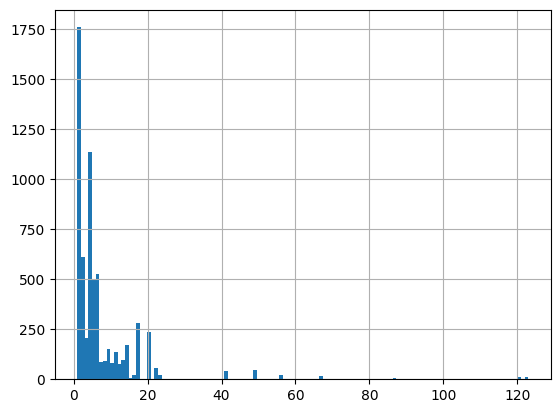

In [80]:
tcad['resstock_count'] = tcad['resstock'].apply(lambda df:len(df))
tcad['resstock_count'].hist(bins=123)

Text(0.5, 0, 'Number of ResStock Matches')

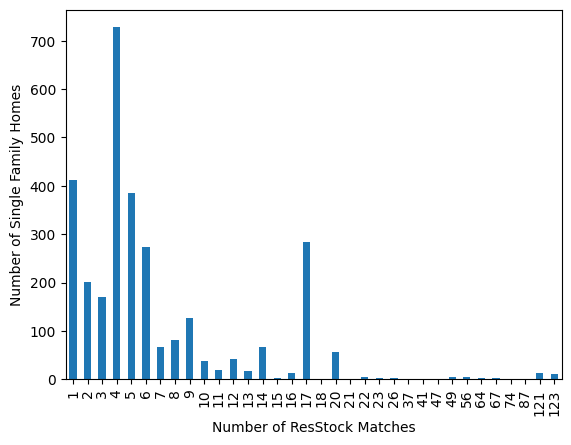

In [81]:
tcad.loc[tcad['situs_zip']=='78733','resstock_count'].value_counts().sort_index().plot(kind='bar')
plt.ylabel('Number of Single Family Homes')
plt.xlabel('Number of ResStock Matches')

Text(0.5, 0, 'Number of ResStock Matches')

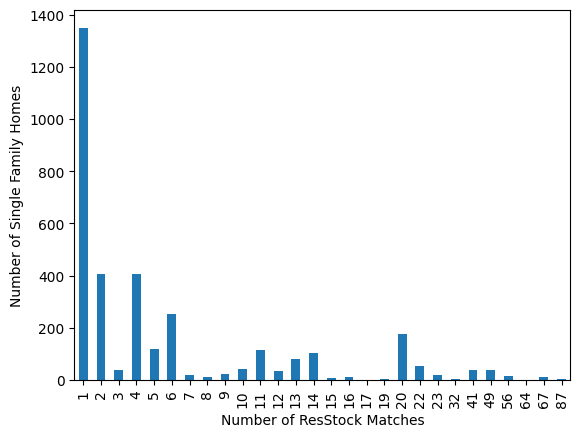

In [82]:
tcad.loc[tcad['situs_zip']=='78741','resstock_count'].value_counts().sort_index().plot(kind='bar')
plt.ylabel('Number of Single Family Homes')
plt.xlabel('Number of ResStock Matches')

In [85]:
tcad['resstock_count'].value_counts().sort_index().to_dict()

{1: 1761,
 2: 610,
 3: 209,
 4: 1135,
 5: 502,
 6: 525,
 7: 84,
 8: 93,
 9: 151,
 10: 81,
 11: 135,
 12: 74,
 13: 98,
 14: 172,
 15: 8,
 16: 22,
 17: 284,
 18: 1,
 19: 3,
 20: 235,
 21: 1,
 22: 57,
 23: 20,
 26: 2,
 32: 2,
 37: 1,
 41: 39,
 47: 1,
 49: 45,
 56: 22,
 64: 3,
 67: 16,
 74: 1,
 87: 4,
 121: 12,
 123: 10}

In [87]:
[col for col in temp.columns if (temp[col].nunique() > 1) and 'out.' not in col]

['in.bathroom_spot_vent_hour',
 'in.bedrooms',
 'in.ceiling_fan',
 'in.clothes_dryer',
 'in.clothes_washer',
 'in.cooking_range',
 'in.cooling_setpoint',
 'in.cooling_setpoint_has_offset',
 'in.cooling_setpoint_offset_magnitude',
 'in.cooling_setpoint_offset_period',
 'in.county_and_puma',
 'in.dishwasher',
 'in.ducts',
 'in.geometry_garage',
 'in.geometry_wall_exterior_finish',
 'in.geometry_wall_type',
 'in.heating_setpoint',
 'in.heating_setpoint_has_offset',
 'in.heating_setpoint_offset_magnitude',
 'in.heating_setpoint_offset_period',
 'in.hot_water_fixtures',
 'in.hvac_cooling_efficiency',
 'in.hvac_heating_efficiency',
 'in.hvac_heating_type',
 'in.hvac_heating_type_and_fuel',
 'in.income',
 'in.infiltration',
 'in.insulation_slab',
 'in.insulation_wall',
 'in.lighting',
 'in.misc_extra_refrigerator',
 'in.misc_freezer',
 'in.misc_pool',
 'in.misc_pool_heater',
 'in.misc_pool_pump',
 'in.occupants',
 'in.orientation',
 'in.plug_load_diversity',
 'in.puma',
 'in.range_spot_vent_h

In [88]:
resstock[resstock['in.sqft']>4000].sort_values('in.sqft')

,in.sqft,in.vintage,in.geometry_stories,in.geometry_floor_area,in.geometry_foundation_type,in.geometry_building_type_height,in.city,in.has_pv,in.cooling_setpoint,in.federal_poverty_level,in.income,in.roof_material
bldg_id,,,,,,,,,,,,
3919,8194.0,2000s,2,4000+,Slab,Single-Family Detached,"TX, Austin",No,78F,400%+,200000+,Composition Shingles
228270,8194.0,1950s,3,4000+,Vented Crawlspace,Single-Family Detached,"TX, Austin",No,76F,300-400%,80000-99999,"Asphalt Shingles, Medium"
253740,8194.0,2000s,2,4000+,Slab,Single-Family Detached,"TX, Austin",No,78F,200-300%,40000-44999,Composition Shingles
269239,8194.0,2010s,2,4000+,Slab,Single-Family Detached,"TX, Austin",No,75F,400%+,200000+,Composition Shingles
304275,8194.0,2000s,2,4000+,Slab,Single-Family Detached,"TX, Austin",No,80F,200-300%,80000-99999,Wood Shingles
...,...,...,...,...,...,...,...,...,...,...,...,...
152271,8194.0,1980s,1,4000+,Vented Crawlspace,Single-Family Detached,"TX, Austin",No,72F,400%+,160000-179999,Composition Shingles
164835,8194.0,2000s,2,4000+,Vented Crawlspace,Single-Family Detached,"TX, Austin",No,75F,400%+,200000+,Composition Shingles
169421,8194.0,1990s,2,4000+,Slab,Single-Family Detached,"TX, Austin",No,75F,400%+,160000-179999,Composition Shingles


<Axes: >

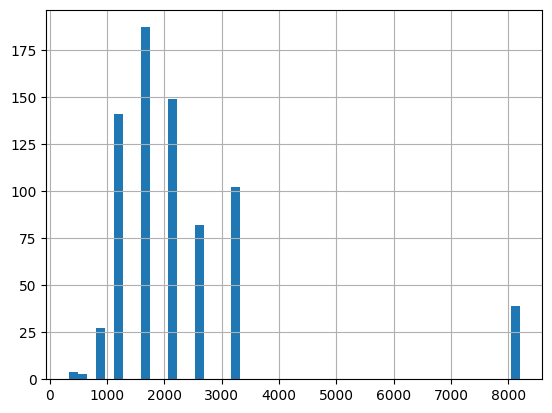

In [89]:
resstock['in.sqft'].hist(bins=50)

In [90]:
tcad[tcad['resstock_count']==20].iloc[5]['resstock']

,in.sqft,in.vintage,in.geometry_stories,in.geometry_floor_area,in.geometry_foundation_type,in.geometry_building_type_height,in.city,in.has_pv,in.cooling_setpoint,in.federal_poverty_level,in.income,in.roof_material
bldg_id,,,,,,,,,,,,
2001,1220.0,1970s,1,1000-1499,Slab,Single-Family Detached,"TX, Austin",No,75F,300-400%,80000-99999,Composition Shingles
63638,1220.0,1970s,1,1000-1499,Slab,Single-Family Detached,"TX, Austin",No,72F,300-400%,60000-69999,Composition Shingles
117631,1220.0,1970s,1,1000-1499,Slab,Single-Family Detached,"TX, Austin",No,76F,400%+,100000-119999,Composition Shingles
164505,1220.0,1970s,1,1000-1499,Slab,Single-Family Detached,"TX, Austin",No,80F,400%+,60000-69999,Composition Shingles
186947,1220.0,1970s,1,1000-1499,Slab,Single-Family Detached,"TX, Austin",No,68F,400%+,120000-139999,Composition Shingles
...,...,...,...,...,...,...,...,...,...,...,...,...
417075,1220.0,1970s,1,1000-1499,Slab,Single-Family Detached,"TX, Austin",No,70F,300-400%,80000-99999,Composition Shingles
501520,1220.0,1970s,1,1000-1499,Slab,Single-Family Detached,"TX, Austin",No,70F,200-300%,30000-34999,Composition Shingles
508515,1220.0,1970s,1,1000-1499,Slab,Single-Family Detached,"TX, Austin",Yes,75F,300-400%,70000-79999,Composition Shingles


In [91]:
temp = resstock_df_raw.loc[[128937,169421,533484,540899]]
cols = [col for col in temp.columns if (temp[col].nunique() > 1) and 'out.' not in col]

temp[cols]

,in.bathroom_spot_vent_hour,in.bedrooms,in.ceiling_fan,in.clothes_dryer,in.clothes_washer,in.cooking_range,in.cooling_setpoint,in.cooling_setpoint_has_offset,in.cooling_setpoint_offset_magnitude,in.cooling_setpoint_offset_period,in.county_and_puma,in.dishwasher,in.ducts,in.geometry_garage,in.geometry_wall_exterior_finish,in.geometry_wall_type,in.heating_setpoint,in.heating_setpoint_has_offset,in.heating_setpoint_offset_magnitude,in.heating_setpoint_offset_period,in.hot_water_fixtures,in.hvac_cooling_efficiency,in.hvac_heating_efficiency,in.hvac_heating_type,in.hvac_heating_type_and_fuel,in.income,in.infiltration,in.insulation_slab,in.insulation_wall,in.lighting,in.misc_extra_refrigerator,in.misc_freezer,in.misc_pool,in.misc_pool_heater,in.misc_pool_pump,in.occupants,in.orientation,in.plug_load_diversity,in.puma,in.range_spot_vent_hour,in.usage_level,in.window_areas,in.windows
bldg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
128937,Hour7,5,None,"Gas, 80% Usage","Standard, 80% Usage","Gas, 80% Usage",75F,No,0F,None,"G4804530, G48005308","290 Rated kWh, 80% Usage","30% Leakage, R-4",3 Car,None,Brick,72F,Yes,3F,Night -1h,50% Usage,"AC, SEER 10","Fuel Boiler, 80% AFUE",Non-Ducted Heating,Natural Gas Fuel Boiler,200000+,4 ACH50,Uninsulated,"Brick, 12-in, 3-wythe, R-19",100% CFL,None,None,Has Pool,None,1.0 HP Pump,5,South,50%,G48005308,Hour11,Low,F12 B12 L12 R12,"Single, Clear, Metal"
169421,Hour18,3,Standard Efficiency,"Electric, 80% Usage","Standard, 80% Usage","Electric, 80% Usage",75F,No,0F,None,"G4804530, G48005305",None,"10% Leakage, R-4",3 Car,None,Brick,70F,No,0F,None,50% Usage,"AC, SEER 13","Fuel Furnace, 80% AFUE",Ducted Heating,Natural Gas Fuel Furnace,160000-179999,4 ACH50,"2ft R10 Under, Horizontal","Brick, 12-in, 3-wythe, R-11",100% LED,None,None,Has Pool,Gas,1.0 HP Pump,2,South,50%,G48005305,Hour1,Low,F6 B6 L6 R6,"Double, Low-E, Non-metal, Air, M-Gain"
533484,Hour10,4,None,"Gas, 100% Usage","EnergyStar, 100% Usage","Gas, 100% Usage",78F,No,0F,None,"G4804530, G48005308",None,"20% Leakage, R-4",3 Car,"Brick, Medium/Dark",Wood Frame,70F,Yes,12F,Night +3h,100% Usage,"AC, SEER 10","Fuel Furnace, 80% AFUE",Ducted Heating,Natural Gas Fuel Furnace,200000+,4 ACH50,Uninsulated,"Wood Stud, R-11",100% LED,None,"EF 12, National Average",None,None,None,3,North,100%,G48005308,Hour16,Medium,F9 B9 L9 R9,"Single, Clear, Metal"
540899,Hour8,3,Standard Efficiency,"Gas, 100% Usage","EnergyStar, 100% Usage","Electric, 100% Usage",78F,Yes,2F,Day Setup and Night Setback +3h,"G4804530, G48005305",None,"10% Leakage, R-4",2 Car,None,Brick,70F,No,0F,None,100% Usage,"AC, SEER 13","Fuel Furnace, 76% AFUE",Ducted Heating,Natural Gas Fuel Furnace,200000+,5 ACH50,Uninsulated,"Brick, 12-in, 3-wythe, R-15",100% Incandescent,EF 15.9,None,None,None,None,2,North,100%,G48005305,Hour16,Medium,F12 B12 L12 R12,"Single, Clear, Non-metal"


In [92]:
tcad[tcad['resstock_count']==0]

,prop_id,imprv_id,prop_val_yr_x,situs_num,situs_street_prefx,situs_street,situs_street_suffix,situs_unit,situs_city,situs_zip,appraised_val,HVAC_area,1ST_floor_area,2ND_floor_area,3RD_floor_area,4TH_floor_area,num_floors,highest_floor,main_area,yr_built,Foundation,Grade Factor,Roof Covering,Roof Style,Shape Factor,land_acres,imprv_val,imprv_state_cd_y,abs_subdv_cd,hood_cd,block,land_hstd_val,land_non_hstd_val,imprv_hstd_val,imprv_non_hstd_val,market_value,ten_percent_cap,assessed_val,imprv_homesite,imprv_homesite_pct,en_exempt,pc_exempt,so_exempt,eco_exempt,vintage,geometry_floor_area,geometry_foundation_type,roof_material,resstock,resstock_count


https://assets.nhgis.org/County-availability.pdf

Williamson Count 4804910
Travis County 4804530

<Axes: >

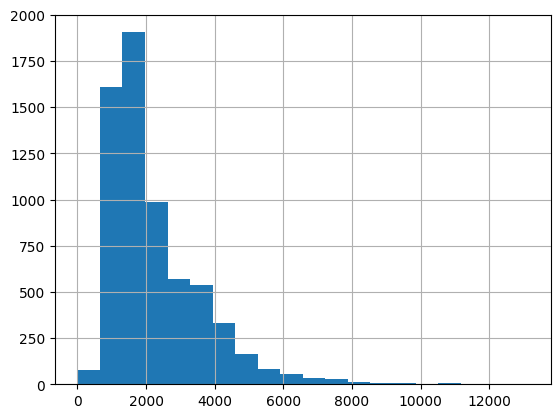

In [93]:
tcad['main_area'].hist(bins=20)

In [94]:
tcad.iloc[0]['resstock'].iloc[0].name

161312

In [95]:
import random

random.seed(2024)

def random_building(row):
    resstock_id = row['resstock'].iloc[random.randint(0,row['resstock_count']-1)].name
    return resstock_id

tcad['selected_resstock_id']= tcad.apply(random_building,axis=1)

In [98]:
tcad.drop(columns=['resstock','resstock_count']).to_parquet('data/processed/3.1-tcad_resstock.parquet')